# Database creation

## Libraries import and connection establishing

In [36]:
import sqlite3, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, re

In [45]:
connection = sqlite3.connect('database.db')
cursor = connection.cursor()

Create tables and relationships from the script

In [38]:
with open("database.sql", 'r') as script:
    statements = script.read().split(';')
    for statement in statements:
        cursor.execute(statement)
connection.commit()
cursor.execute("SELECT name FROM sqlite_master;")
cursor.fetchall()

[('notebook',),
 ('sqlite_autoindex_notebook_1',),
 ('sqlite_sequence',),
 ('configuration',),
 ('metrics',)]

Functions to extract images and metrics from a notebook
metrics: [Specificity, recall, roc auc, f1-score, precision]

In [66]:
def getNotebook(notebook):
    if notebook.startswith('c'):
        notebook = open("".join(["../Notebooks/trainings/convnext/",notebook,'.ipynb']))
    elif notebook.startswith('r'):
        notebook = open("".join(["../Notebooks/trainings/resnetv2/",notebook,'.ipynb']))
    elif notebook.startswith('x'):
        notebook = open("".join(["../Notebooks/trainings/xception/",notebook,'.ipynb']))
    return notebook.read().splitlines()

def getNotebookMetrics(notebook):
    images = []
    patterns = {
        'bowensDisease': re.compile(r'^"\s*Bowens disease\s+([\d.]+)\s+'),
        'basalCellCarcinoma': re.compile(r'^"\s*Basal cell carcinoma\s+([\d.]+)\s+'),
        'benignKeratosis': re.compile(r'^"\s*Benign keratosis\s+([\d.]+)\s+'),
        'dermatofibroma': re.compile(r'^"\s*Dermatofibroma\s+([\d.]+)\s+'),
        'vascularLesion': re.compile(r'^"\s*Vascular lesion\s+([\d.]+)\s+'),
        'melanoma': re.compile(r'^"\s*Melanoma\s+([\d.]+)\s+'),
        'melanocyticNevi': re.compile(r'^"\s*Melanocytic nevi\s+([\d.]+)\s+')
    }
    metrics = {key: [] for key in patterns}
    config = []

    lines = getNotebook(notebook)
    for line in reversed(lines):
        if line.strip().startswith('\"image/') and len(images) < 13:
            parts = line.split(': ')
            images.append((parts[0].strip('"'), parts[1].strip().strip('"').replace('\\n','')))
        elif line.strip().startswith('\"Test set evaluation:'):
            values = re.findall(r'\d+\.\d+|\d+', line.strip())
            valuesTest = [float(value) for value in values]
        elif line.strip().startswith('\"Validation set evaluation:'):
            values = re.findall(r'\d+\.\d+|\d+', line.strip())
            valuesValidation = [float(value) for value in values]
        elif line.strip().startswith('\"useCallback = ') or line.strip().startswith('\"customOptimizer = ') or line.strip().startswith('\"minMaxScalerNorm = ') or line.strip().startswith('\"standardScalerNorm = ') or line.strip().startswith('\"dataAugmentation = ') or line.strip().startswith('\"segmentation = ') or line.strip().startswith('\"balanceClasses = ') or line.strip().startswith('\"freezeLayers = ') or line.strip().startswith('\"transferLearning = '):
            match = re.search(r'True|False', line)
            config.append(match.group(0) == 'True')
        else:
            for key, pattern in patterns.items():
                match = pattern.match(line.strip())
                if match:
                    metrics[key].append(float(match.group(1)))
                    break

    return config, images, [metrics[key] for key in patterns], [valuesTest,valuesValidation]

def displayNotebookImages(images):
    for image_format, image_data in images:
        decoded_image = io.BytesIO(base64.b64decode(image_data))
        img = mpimg.imread(decoded_image, format=image_format)
        plt.subplots(figsize=(10, 10))
        plt.imshow(img)

def displayDatabaseImages(images):
    for img in images:
        decoded_image = io.BytesIO(base64.b64decode(img[0]))
        img = mpimg.imread(decoded_image, format='png')
        plt.subplots(figsize=(10, 10))
        plt.imshow(img)

# config, images, metrics, setsMetrics = getNotebookMetrics('xceptionAll')
# for metric in metrics:
#     print(metric)
# print(setsMetrics)
# print(config)
# displayNotebookImages(images)

## Insert information into database

In [40]:
def checkIfExists(name):
    cursor.execute("SELECT COUNT(1) FROM notebook WHERE name = \"" + name + "\";")
    return cursor.fetchall()[0][0]

def insertConfiguration(config):
    scaler = "None"
    if config[2]:
        scaler = "MinMaxScaler"
    elif config[3]:
        scaler = "StandardScaler"
    cursor.execute("""
        INSERT INTO configuration
        (transfer_learning,freeze_layers,balance_classes,segmentation,data_augmentation,normalization,custom_optimizer,callback) \
        VALUES
        (?,?,?,?,?,?,?,?);""",
        (str(config[8]),str(config[7]),str(config[6]),str(config[5]),str(config[4]),scaler,str(config[1]),str(config[0])))
    connection.commit()
    cursor.execute('SELECT id FROM configuration ORDER BY id DESC LIMIT 1;')
    return cursor.fetchone()[0]

def insertNotebook(name, images, setMetrics, configId):
    if name.startswith('c'):
        architecture = "ConvNeXt"
    elif name.startswith('r'):
        architecture = "ResNetV2"
    else:
        architecture = "Xception"
    query = """
        INSERT INTO notebook
        (name, architecture, confusion_matrix, loss, accuracy, auc, recall, precision, false_positives, false_negatives, true_negatives, true_positives, val_loss, val_accuracy, val_auc, val_recall, val_precision, val_false_positives, val_false_negatives, val_true_negatives, val_true_positives, loss_epochs, accuracy_epochs, auc_epochs, recall_epochs, precision_epochs, configuration_id)
        VALUES
        (?, ?, ?,
        ?, ?, ?, ?, ?, ?, ?, ?, ?,
        ?, ?, ?, ?, ?, ?, ?, ?, ?,
        ?, ?, ?, ?, ?, ?);"""
    values = (name, architecture, images[7][1],
            setMetrics[0][0], setMetrics[0][1], setMetrics[0][2], setMetrics[0][3], setMetrics[0][4], setMetrics[0][5], setMetrics[0][6], setMetrics[0][7],setMetrics[0][8],
            setMetrics[1][0], setMetrics[1][1], setMetrics[1][2], setMetrics[1][3], setMetrics[1][4], setMetrics[1][5], setMetrics[1][6], setMetrics[1][7],setMetrics[1][8],
            images[12][1], images[11][1], images[10][1], images[9][1], images[8][1], configId)
    cursor.execute(query, values)
    connection.commit()
    cursor.execute('SELECT id FROM notebook ORDER BY id DESC LIMIT 1;')
    return cursor.fetchone()[0]

def insertMetrics(images, metrics, notebookId):
    i = 6
    j = 0
    for cancerType in ["Bowens_disease","Basal_cell_carcinoma","Benign_keratosis","Dermatofibroma","Vascular_lesion","Melanoma","Melanocytic_nevi"]:
        cursor.execute("""
            INSERT INTO metrics
            (type,confusion_matrix,precision,f1_score,roc_auc,recall,specificity,notebook_id)
            VALUES
            (?,?,?,?,?,?,?,?);""",
            (cancerType,images[i][1],metrics[j][4],metrics[j][3],metrics[j][2],metrics[j][1],metrics[j][0],notebookId))
        i = i - 1
        j = j + 1
    connection.commit()

In [41]:
names = ["convnextAll","resnetAll","xceptionAll","convnextBalancedNormTransf","resnetBalancedNormTransf","xceptionBalancedNormTransf","convnextDataaugmentation","resnetDataaugmentation","xceptionDataaugmentation","convNextRaw","resNetRaw","xceptionRaw","convnextRawBalanced","resnetRawBalanced","xceptionRawBalanced","convnextSegmentation","resnetSegmentation","xceptionSegmentation","convnextTransf","resnetTransf","xceptionTransf"]

for name in names:
    if not checkIfExists(name):
        config, images, metrics, setsMetrics = getNotebookMetrics(name)
        if name.startswith('c'):
            configId = insertConfiguration(config)
        notebookId = insertNotebook(name, images, setsMetrics, configId)
        insertMetrics(images, metrics, notebookId)

Test if information have been saved

C:\Users\Henrique\AppData\Local\Temp\ipykernel_16116\960909710.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(figsize=(10, 10))


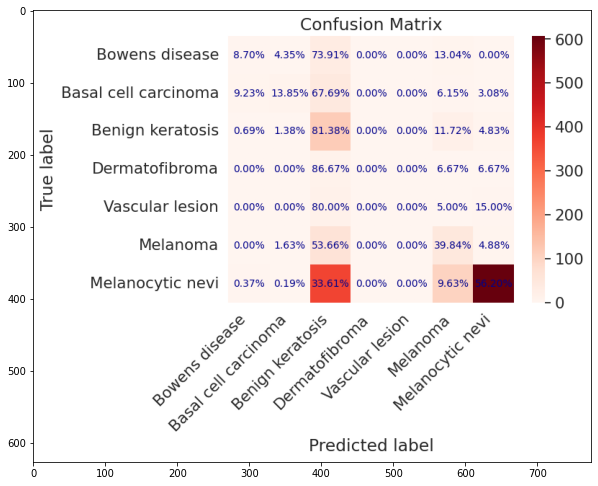

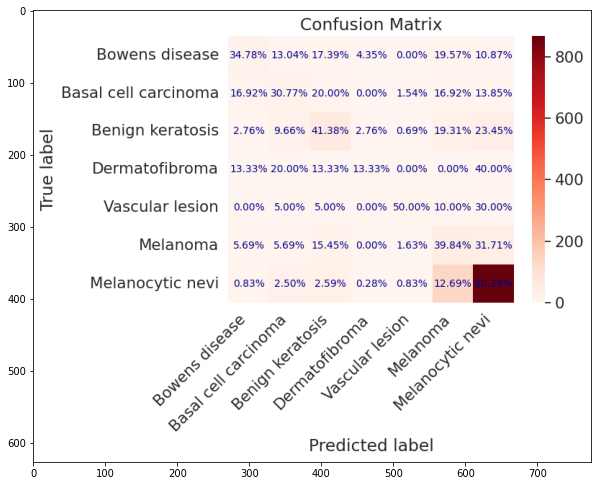

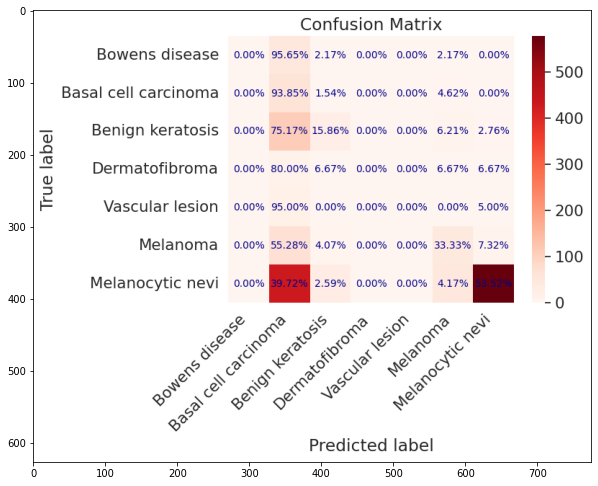

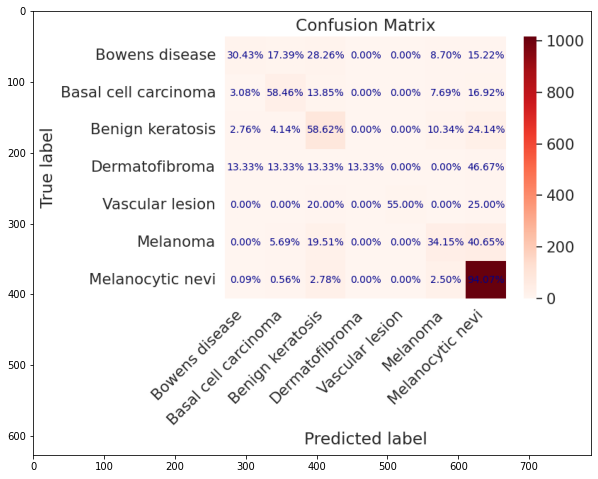

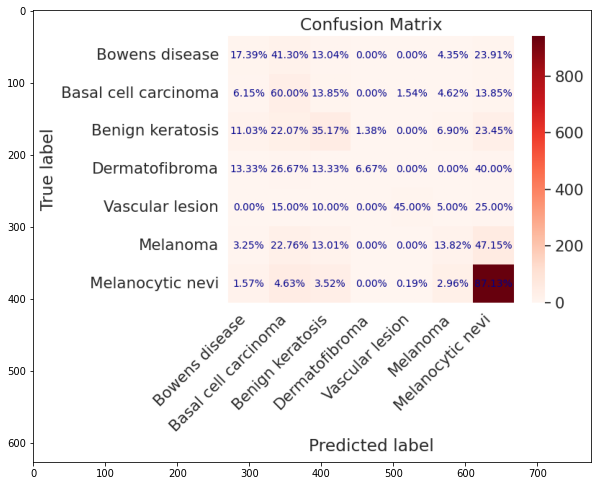

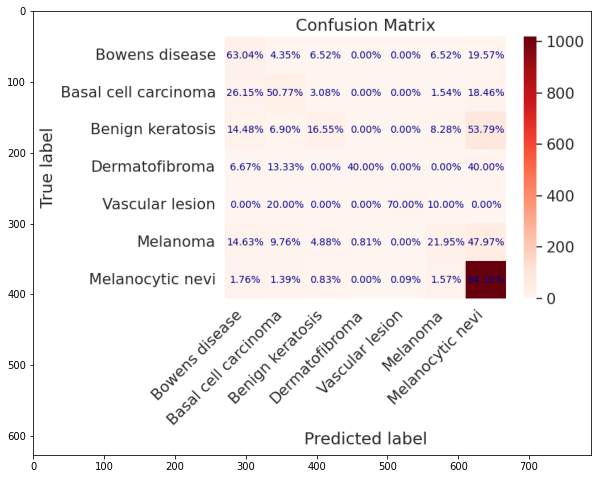

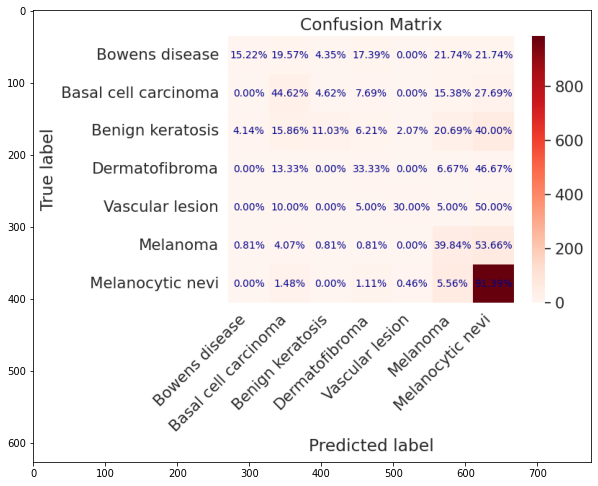

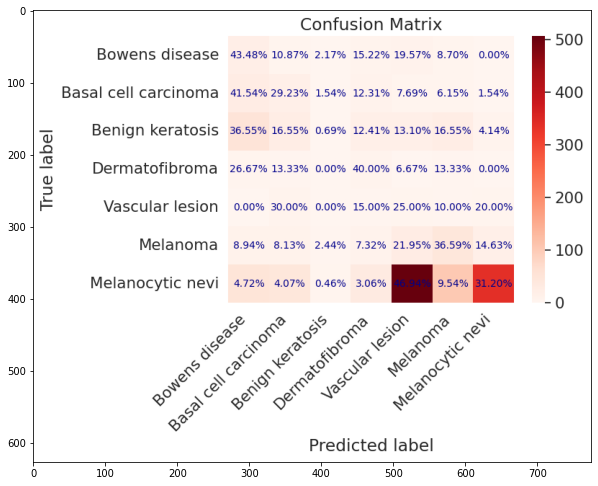

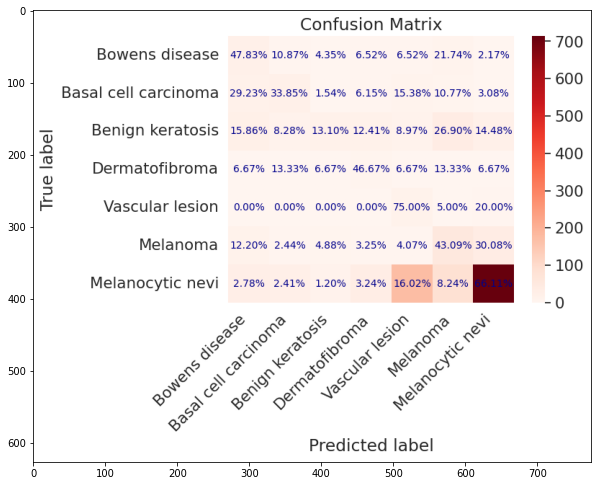

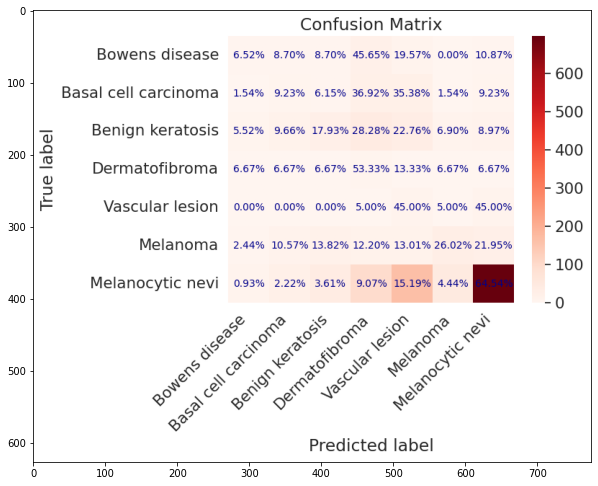

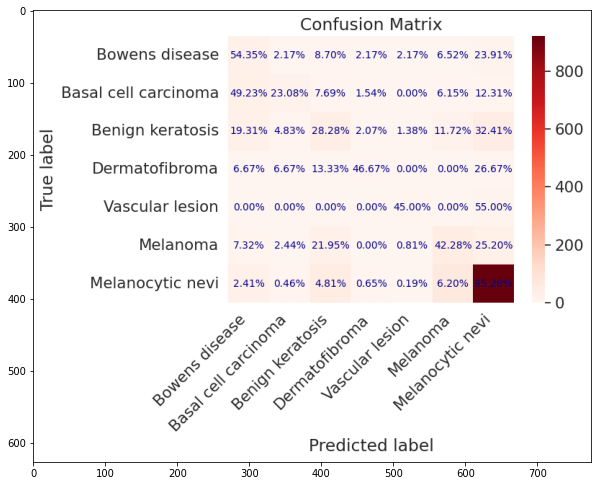

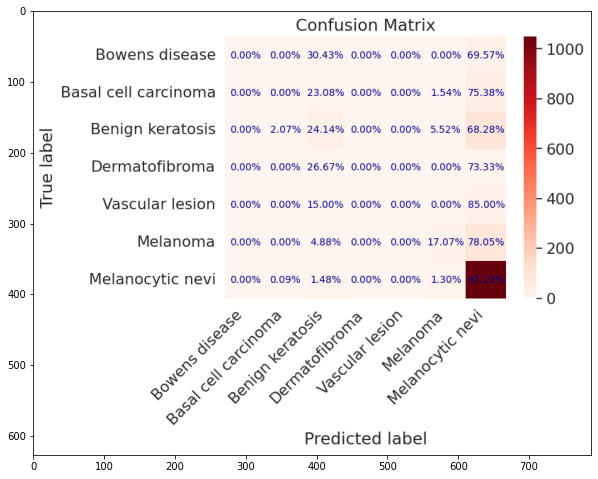

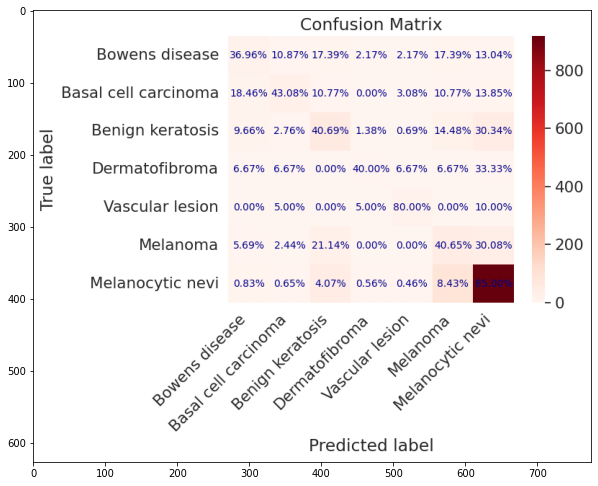

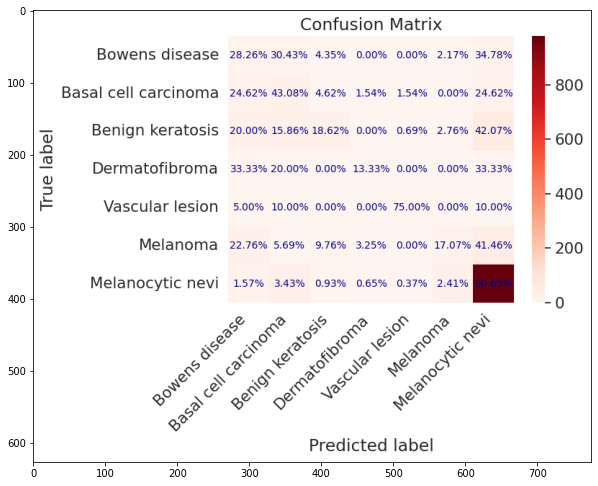

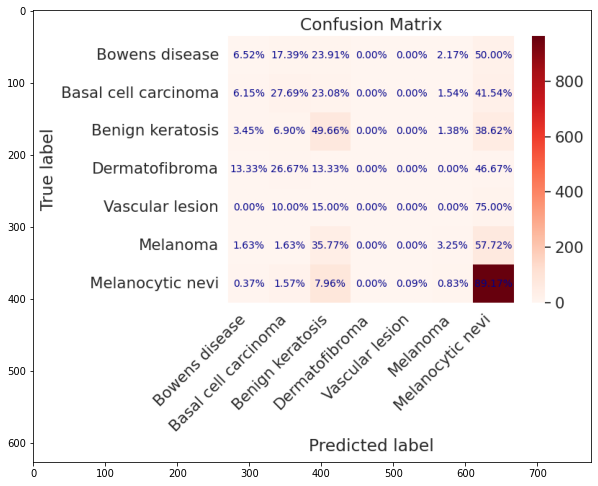

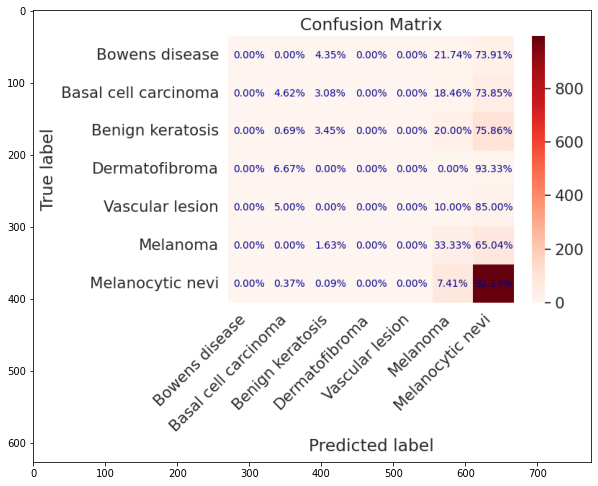

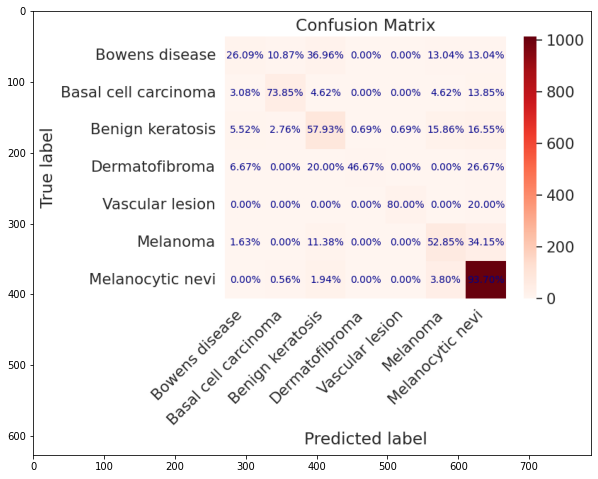

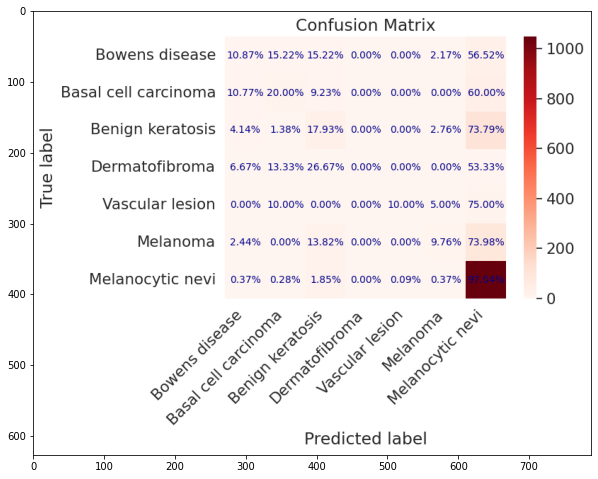

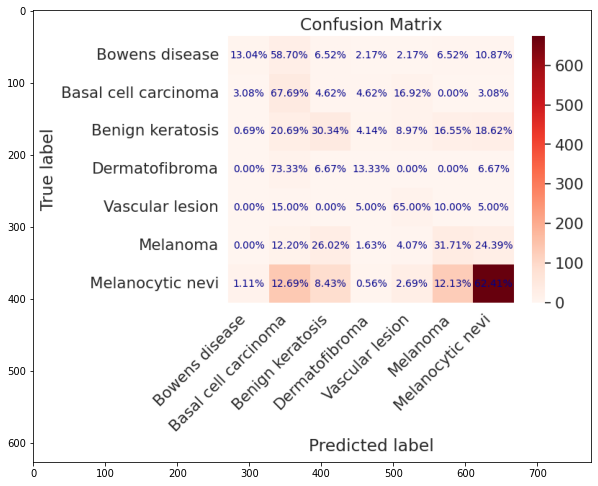

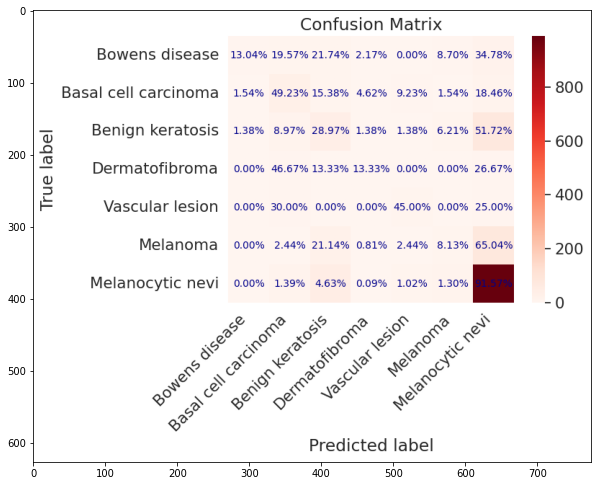

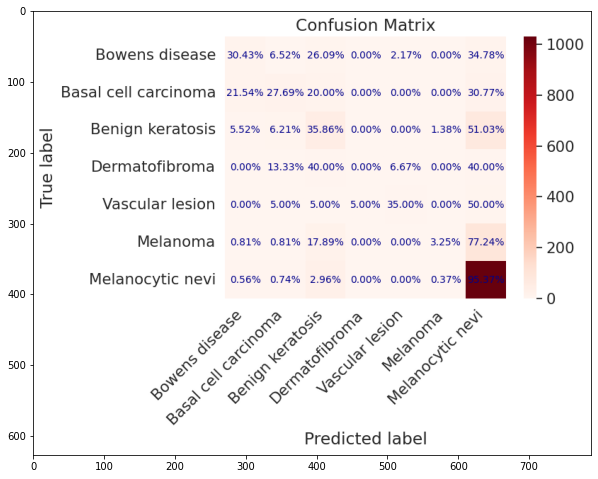

In [68]:
cursor.execute('SELECT name,accuracy,loss FROM notebook order by accuracy desc;')
cursor.execute('SELECT confusion_matrix from notebook order by accuracy desc;')
images = cursor.fetchall()
displayDatabaseImages(images)


Close the current connection

In [69]:
connection.close()